<a href="https://colab.research.google.com/github/conwayjw97/Image-Colourisation-with-Deep-Learning/blob/master/src/CGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Select your Dataset

In [0]:
# Insert an integer value for the DATASET_CHOICE variable below
# 0 = Shape Set
# 1 = cifar10 (You can also choose a class with the CIFAR10_CLASS variable)
# 2 = Celeb faces
# 3 = ImageNette (You must choose a category with the IMAGENETTE_CATEGORY variable)
DATASET_CHOICE = 2

# If you wish to use a specific cifar10 class, specify one here, otherwise assign the variable to None
# 0 = airplane
# 1 = automobile
# 2 = bird
# 3 = cat
# 4 = deer										
# 5 = dog
# 6 = frog
# 7 = horse
# 8 = ship
# 9 = truck
CIFAR10_CLASS = 6

# If using imagenette specify the image category to train on here
# Choose one of the following: "dog", "paraglider", "golfball", "church", "fish"
IMAGENETTE_CATEGORY = "fish"

# Choose Whether to Train or Load a Model

In [0]:
# True = Load and output results for a model trained on the chosen dataset
# False = Train on the chosen dataset and output results 
LOAD_MODEL = True

# Provide the filename of the model to load/save
# Leave as None to use the default filename which will be named after the dataset
MODEL_NAME = None

# If LOAD_MODEL = False, choose whether to save the model
# True = Train and save
# False = Train only
SAVE_MODEL = True

# Define Training Hyper-Parameters

In [0]:
BATCH_SIZE = 512
TRAINING_EPOCHS = 10

# Import Statements

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import datetime, os
import matplotlib.pyplot as plt
import numpy as np
import math
import time
from scipy.ndimage.filters import gaussian_filter1d
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, BatchNormalization, Flatten, Dense
from tensorflow.keras.models import Model, model_from_json
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import io
from skimage.transform import resize
from google.colab import drive, files

# Load Dataset

Initialized empty Git repository in /content/.git/
Updating origin
remote: Enumerating objects: 225, done.
remote: Counting objects: 100% (225/225), done.
remote: Compressing objects: 100% (219/219), done.
remote: Total 15411 (delta 95), reused 77 (delta 6), pack-reused 15186
Receiving objects: 100% (15411/15411), 737.03 MiB | 36.98 MiB/s, done.
Resolving deltas: 100% (580/580), done.
From https://github.com/conwayjw97/Image-Colourisation-with-Deep-Learning
 * [new branch]      master     -> origin/master
fatal: ambiguous argument 'HEAD': unknown revision or path not in the working tree.
Use '--' to separate paths from revisions, like this:
'git <command> [<revision>...] -- [<file>...]'
Removing .config/
Removing sample_data/
From https://github.com/conwayjw97/Image-Colourisation-with-Deep-Learning
 * branch            master     -> FETCH_HEAD


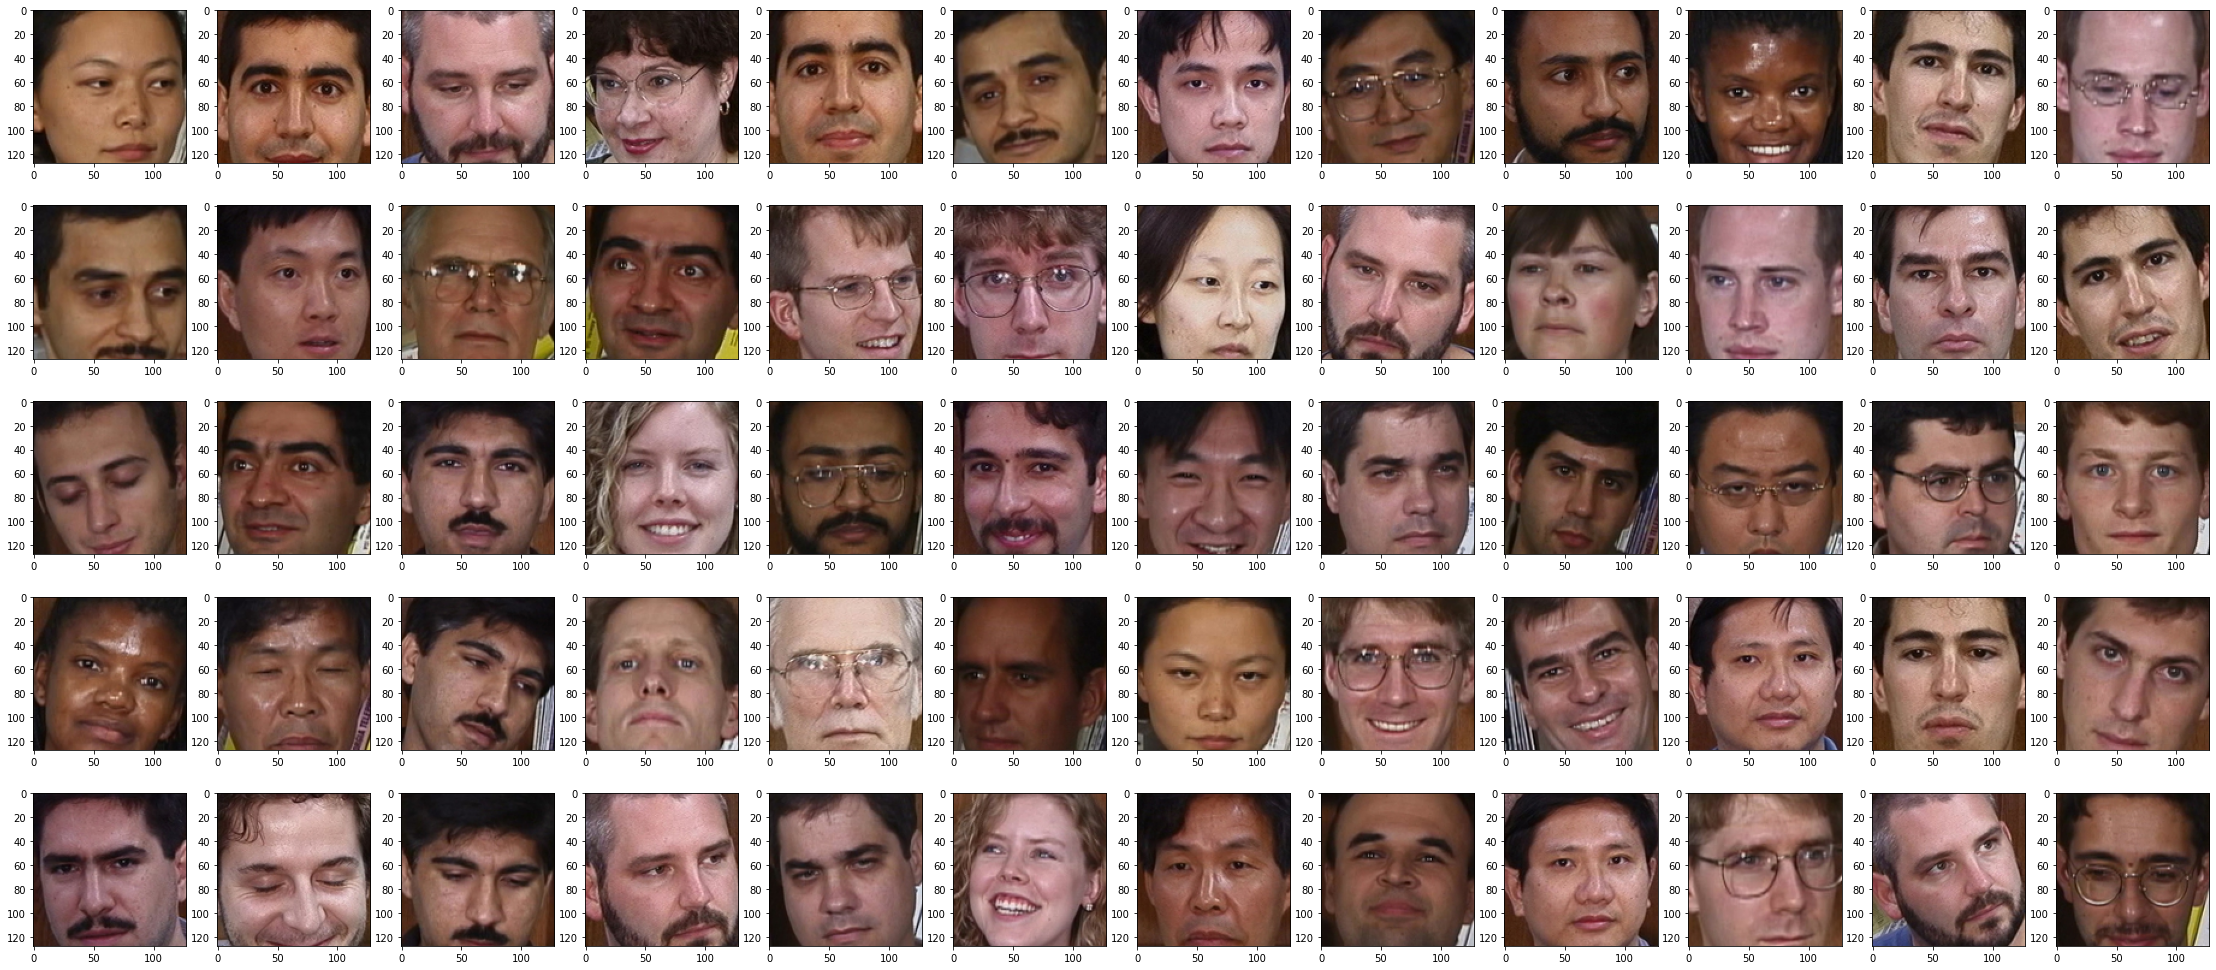

In [5]:
# Initialise empty repository to pull data into
!git init 
# Add the remote origin
!git remote add origin -f https://github.com/conwayjw97/Image-Colourisation-with-Deep-Learning.git
# Reset the HEAD in case a different folder was already pulled
!git reset --hard HEAD
!git clean -f -d
# Tell git we are checking out specific folders
!git config core.sparsecheckout true

# Shape Set
if(DATASET_CHOICE == 0):
  # Recursively checkout the dataset and models folders
  !echo "data/datasets/ShapeSet/*" >> .git/info/sparse-checkout
  !echo "data/models/cgan/*" >> .git/info/sparse-checkout
  # Pull dataset from repository
  !git pull origin master

  # Load and shuffle
  images = []
  for image in io.imread_collection("data/datasets/ShapeSet/*.jpg"): 
    if(image.shape == (128, 128, 3)):
      images.append(np.array(image))
  indices = np.arange(len(images))
  np.random.shuffle(indices)
  images = np.array(images)[indices]
  train_images = np.array(images[1:-1:2])
  test_images = np.array(images[0:-2:2])

  # Scale pixel data to [0,1]
  train_images = train_images / 255.0
  test_images = test_images / 255.0

  # Image output variables, change these to see different images on the results
  output_count = 9
  index_offset = 0

  # Output portion of the dataset
  fig = plt.figure(figsize=(39, 21))
  for i in range(output_count):
    ax = fig.add_subplot(1,output_count,i+1)
    plt.imshow(images[i])

  # Convert to YUV
  train_yuv  = tf.image.rgb_to_yuv(train_images)
  train_y = (train_images[:,:,:,0] + train_images[:,:,:,1] + train_images[:,:,:,2]) / 3
  train_y = tf.expand_dims(train_y[:,:,:], 3)
  train_uv = train_yuv[:,:,:,1:]
  test_yuv = tf.image.rgb_to_yuv(test_images)
  test_y = (test_images[:,:,:,0] + test_images[:,:,:,1] + test_images[:,:,:,2]) / 3
  test_y = tf.expand_dims(test_y[:,:,:], 3)
  test_uv = test_yuv[:,:,:,1:]

  # Give default model name if needed
  if(MODEL_NAME is None):
    MODEL_NAME = "ShapeSet"

  # Adjust batch size if it's too big for the dataset
  if(BATCH_SIZE > 8):
    BATCH_SIZE = 8 

# Cifar10
elif(DATASET_CHOICE == 1):
  # Recursively checkout the models folders
  !echo "data/models/cgan/*" >> .git/info/sparse-checkout
  # Pull dataset from repository
  !git pull origin master

  # Load and scale dataset
  (train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
  train_images = train_images / 255.0
  test_images = test_images / 255.0

  # Prune dataset to chosen class
  if(CIFAR10_CLASS is not None):
    class_train_indices = np.argwhere(train_labels == CIFAR10_CLASS)
    train_images = train_images[class_train_indices[:,0]]
    train_labels = train_labels[class_train_indices[:,0]]
    class_test_indices = np.argwhere(test_labels == CIFAR10_CLASS)
    test_images = test_images[class_test_indices[:,0]]
    test_labels = test_labels[class_test_indices[:,0]]
  
  # Output portion of the dataset
  image_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
  fig = plt.figure(figsize=(39, 21))
  count = 0
  for i in range(5):
    for j in range(12):
      ax = fig.add_subplot(6,12,count+1)
      if(CIFAR10_CLASS is None):
        plt.title(image_labels[int(train_labels[count])])
      plt.imshow(train_images[count])
      count += 1

  # Image output variables, change these to see different images on the results
  output_count = 12
  index_offset = 20

  # Convert to YUV
  train_yuv  = tf.image.rgb_to_yuv(train_images)
  train_y = tf.expand_dims(train_yuv[:,:,:,0], 3)
  train_uv = train_yuv[:,:,:,1:]
  test_yuv = tf.image.rgb_to_yuv(test_images)
  test_y = tf.expand_dims(test_yuv[:,:,:,0], 3)
  test_uv = test_yuv[:,:,:,1:]

  # Give default model name if needed
  if(MODEL_NAME is None):
    if(CIFAR10_CLASS is not None):
      MODEL_NAME = "Cifar10-" + str(CIFAR10_CLASS)
    else:
      MODEL_NAME = "Cifar10"

# Faces Images
elif(DATASET_CHOICE == 2):
  # Recursively checkout the dataset and models folders
  !echo "data/datasets/face_images/*" >> .git/info/sparse-checkout
  !echo "data/models/cgan/*" >> .git/info/sparse-checkout
  # Pull dataset from repository
  !git pull origin master

  images = train_images = test_images = []
  for image in io.imread_collection("data/datasets/face_images/*.jpg"): 
    images.append(resize(image, (128, 128)))
  train_images = np.array(images)[0:-1:2,:,:,:]
  test_images = np.array(images)[1::2,:,:,:]

  # Output portion of the dataset
  fig = plt.figure(figsize=(39, 21))
  count = 0
  for i in range(5):
    for j in range(12):
      ax = fig.add_subplot(6,12,count+1)
      plt.imshow(train_images[30+count])
      count += 1

  # Image output variables, change these to see different images on the results
  index_offset = 20
  output_count = 12

  # Convert to YUV
  train_yuv  = tf.image.rgb_to_yuv(train_images)
  train_y = tf.expand_dims(train_yuv[:,:,:,0], 3)
  train_uv = train_yuv[:,:,:,1:]
  test_yuv = tf.image.rgb_to_yuv(test_images)
  test_y = tf.expand_dims(test_yuv[:,:,:,0], 3)
  test_uv = test_yuv[:,:,:,1:]

  # Give default model name if needed
  if(MODEL_NAME is None):
    MODEL_NAME = "Faces"

  # Adjust batch size if it's too big for the dataset
  if(BATCH_SIZE > 128):
    BATCH_SIZE = 128

# Imagenette
elif(DATASET_CHOICE == 3):
  # Recursively checkout the dataset and models folders
  !echo "data/datasets/imagenette2-160/*" >> .git/info/sparse-checkout
  !echo "data/models/cgan/*" >> .git/info/sparse-checkout
  # Pull dataset from repository
  !git pull origin master

  # Load and resize dataset
  categories = {"dog":"n02102040", "paraglider":"n03888257", "golfball":"n03445777", "church":"n03028079", "fish":"n01440764"}
  print("Loading and resizing training and testing images, this may take a few minutes.")
  images = []
  for image in io.imread_collection("data/datasets/imagenette2-160/train/" + categories[IMAGENETTE_CATEGORY] + "/*.JPEG"): 
    image = np.array(resize(image, (128, 128)))
    if(image.shape == (128, 128, 3)):
      images.append(image)
  train_images = np.array(images)
  images = []
  for image in io.imread_collection("data/datasets/imagenette2-160/val/" + categories[IMAGENETTE_CATEGORY] + "/*.JPEG"): 
    image = np.array(resize(image, (128, 128)))
    if(image.shape == (128, 128, 3)):
      images.append(image)
  test_images = np.array(images)

  # Output portion of the dataset
  fig = plt.figure(figsize=(39, 21))
  count = 0
  for i in range(5):
    for j in range(12):
      ax = fig.add_subplot(6,12,count+1)
      ax.axes.get_xaxis().set_visible(False)
      ax.axes.get_yaxis().set_visible(False)  
      plt.imshow(train_images[30+count])
      count += 1

  # Image output variables, change these to see different images on the results
  index_offset = 0
  output_count = 12

  # Convert to YUV
  train_yuv  = tf.image.rgb_to_yuv(train_images)
  train_y = tf.expand_dims(train_yuv[:,:,:,0], 3)
  train_uv = train_yuv[:,:,:,1:]
  test_yuv = tf.image.rgb_to_yuv(test_images)
  test_y = tf.expand_dims(test_yuv[:,:,:,0], 3)
  test_uv = test_yuv[:,:,:,1:]

  # Give default model name if needed
  if(MODEL_NAME is None):
    MODEL_NAME = "Imagenette-" + categories[IMAGENETTE_CATEGORY]

# Generator Definition

In [6]:
# Input layer
y_input = Input(shape=(train_y.shape[1], train_y.shape[2], 1))

# Hidden layers
layer = Conv2D(8, (3, 3), activation='relu')(y_input)
layer = Conv2D(32, (3, 3), activation='relu', padding='same', strides=2)(layer)
layer = BatchNormalization(momentum=0.8)(layer)
layer = Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)(layer)
layer = BatchNormalization(momentum=0.8)(layer)
layer = Conv2D(128, (3, 3), activation='relu', padding='same', strides=2)(layer)
layer = UpSampling2D((2, 2))(layer)
layer = BatchNormalization(momentum=0.8)(layer)
layer = Conv2D(128, (3, 3), activation='relu', padding='same')(layer)
layer = UpSampling2D((2, 2))(layer)
layer = Conv2D(64, (3, 3), activation='relu', padding='same')(layer)
layer = BatchNormalization(momentum=0.8)(layer)
layer = Conv2D(32, (3, 3), activation='relu', padding='same')(layer)
layer = UpSampling2D((2, 2))(layer)

# Output layer
uv_out = Conv2D(2, (3, 3), activation='tanh', padding='same')(layer)

# Instantiate generator
generator = Model(y_input, uv_out, name='generator')
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 126, 8)       80        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 63, 63, 32)        2336      
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       73

# Discriminator Definition

In [7]:
# Input layer
uv_input = Input(shape=(train_uv.shape[1], train_uv.shape[2], 2))

# Hidden layers
layer = Conv2D(16, (3,3), activation='relu', padding='same')(uv_input)
layer = Conv2D(16, (3,3), activation='relu', strides=(2,2), padding='same')(layer)
layer = Conv2D(32, (3,3), activation='relu', padding='same')(layer)
layer = Conv2D(32, (3,3), activation='relu', strides=(2,2), padding='same')(layer)
layer = Conv2D(64, (3,3), activation='relu', padding='same')(layer)
layer = Conv2D(128, (3,3), activation='relu', strides=(2,2), padding='same')(layer)
layer = Conv2D(256, (3,3), activation='relu', padding='same')(layer)
layer = Flatten()(layer)

# Output layer
validity_output = Dense(1, activation='sigmoid')(layer)

# Instantiate discriminator
discriminator = Model(uv_input, validity_output, name='discriminator')
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 2)]     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 128, 128, 16)      304       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 16)        2320      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 32)        4640      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 128)     

# Combined CGAN Definition

In [0]:
# Instantiate optimiser
opt = tf.keras.optimizers.Adam(0.0002, 0.5)

# Compile the discriminator
discriminator.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# The generator takes a y channel as input and generates uv channels
y_channel = Input(shape=(train_y.shape[1], train_y.shape[2], 1))
uv_channels = generator(y_channel)

# For the combined model we will only train the generator
discriminator.trainable = False
validity = discriminator(uv_channels)

# The combined models takes y channels as input => generates uv channels => determines validity
gan = Model(y_channel, validity)
gan.compile(optimizer=opt, loss='binary_crossentropy')

gen_loss_history = []
disc_loss_history = []
disc_acc_history = []

# CGAN Training/Loading

In [10]:
load_dir = "data/models/cgan/"
save_dir = "output/models/"

# Load model
if(LOAD_MODEL):
  # Load disriminator structure
  json_file = open(load_dir + MODEL_NAME + "-Discriminator.json", 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  discriminator = model_from_json(loaded_model_json)

  # Load generator structure
  json_file = open(load_dir + MODEL_NAME + "-Generator.json", 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  generator = model_from_json(loaded_model_json)

  # Load weights for each
  discriminator.load_weights(load_dir + MODEL_NAME + "-Discriminator.h5", by_name=False)
  generator.load_weights(load_dir + MODEL_NAME + "-Generator.h5", by_name=False)

  # Load loss history
  gen_loss_history = np.loadtxt(load_dir + MODEL_NAME + "-loss.csv", delimiter=',')
  disc_loss_history = np.loadtxt(load_dir + MODEL_NAME + "-val_loss.csv", delimiter=',')
  disc_acc_history = np.loadtxt(load_dir + MODEL_NAME + "-val_acc.csv", delimiter=',')

  print("Loaded model from disk")

# Train model
else:
  time_total = 0

  # Data generator
  datagen = ImageDataGenerator()

  training_start = time.time()
  # Training loop
  for epoch in range(1, TRAINING_EPOCHS+1):
    start = time.time()
    batches = 0

    # Batch loading loop
    for x_batch, y_batch in datagen.flow(train_y, train_uv, batch_size=BATCH_SIZE):
      # Generate a batch of new images
      gen_imgs = generator.predict(x_batch)

      # Train the discriminator
      d_loss_real = discriminator.train_on_batch(y_batch, np.ones((y_batch.shape[0], 1)))
      d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((gen_imgs.shape[0], 1)))
      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

      # The generator wants the discriminator to label the generated samples
      # as valid (ones)
      valid_y = np.array([1] * gen_imgs.shape[0])

      # Train the generator
      g_loss = gan.train_on_batch(x_batch, valid_y)

      batches += 1

      # Break the loop manually, otherwise the generator loops indefinitely
      if batches >= len(train_y) / BATCH_SIZE:
          break

    # Output training progress
    time_total += time.time()-start
    print("Epoch %d/%d - Time %fs - Estimated time left %ds - Discriminator loss: %f, acc.: %.2f%% - Generator loss: %f" % (epoch, TRAINING_EPOCHS, time.time()-start, (time_total/epoch)*(TRAINING_EPOCHS-epoch), d_loss[0], 100*d_loss[1], g_loss))
    gen_loss_history.append(g_loss)
    disc_loss_history.append(d_loss[0])
    disc_acc_history.append(100*d_loss[1])

  print("Total time taken: %ds" % (time.time()-training_start))

  if(SAVE_MODEL):
    !mkdir -p output/models/
    
    # Save discriminator structure
    model_json = discriminator.to_json()
    with open(save_dir + MODEL_NAME + "-Discriminator.json", "w") as json_file:
        json_file.write(model_json)

    # Save generator structure
    model_json = generator.to_json()
    with open(save_dir + MODEL_NAME + "-Generator.json", "w") as json_file:
        json_file.write(model_json)

    # Save weights for each model
    discriminator.save_weights(save_dir + MODEL_NAME + "-Discriminator.h5")
    generator.save_weights(save_dir + MODEL_NAME + "-Generator.h5")

    # Save loss history
    np.savetxt(save_dir + MODEL_NAME + "-loss.csv", gen_loss_history, delimiter=',')
    np.savetxt(save_dir + MODEL_NAME + "-val_loss.csv", disc_loss_history, delimiter=',')
    np.savetxt(save_dir + MODEL_NAME + "-val_acc.csv", disc_acc_history, delimiter=',')

    print("Saved model to disk")

Loaded model from disk


# Diagnostic Learning Curve

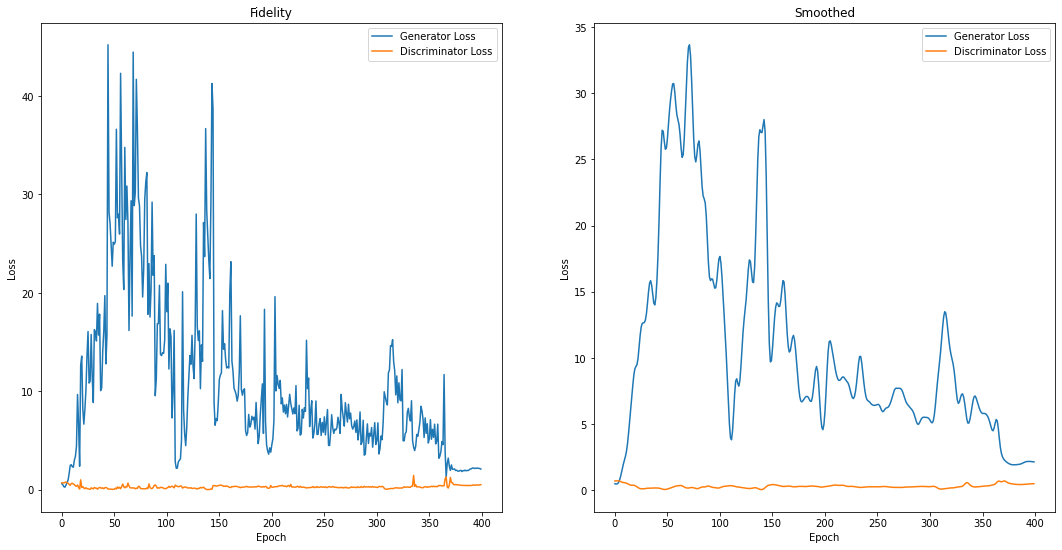

In [11]:
fig = plt.figure(figsize=(38, 9))

# Graph training and validation loss
fig.add_subplot(1,4,1)
plt.title("Fidelity")
plt.plot(gen_loss_history, label="Generator Loss")
plt.plot(disc_loss_history, label="Discriminator Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig("Fidelity.png")

# Graph training and validation loss after smoothing with a gaussian filter
fig.add_subplot(1,4,2)
plt.title("Smoothed")
plt.plot(gaussian_filter1d(gen_loss_history, sigma=2), label="Generator Loss")
plt.plot(gaussian_filter1d(disc_loss_history, sigma=2), label="Discriminator Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig("Smooted.png")

# Training Results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

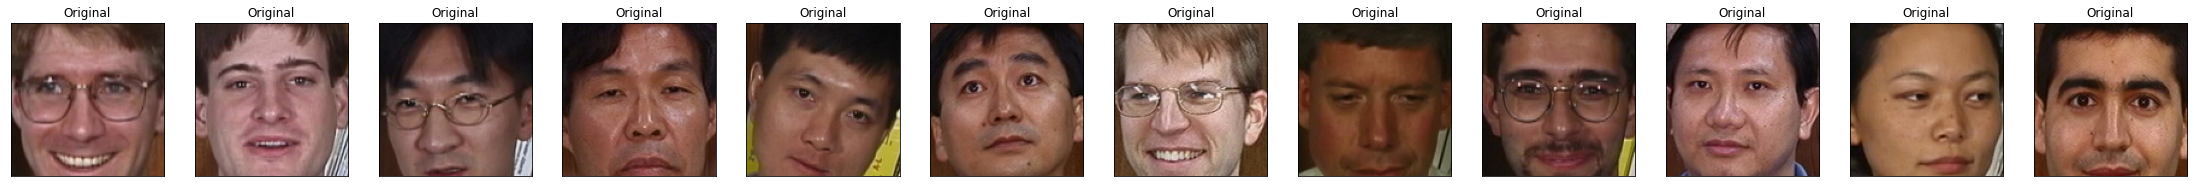

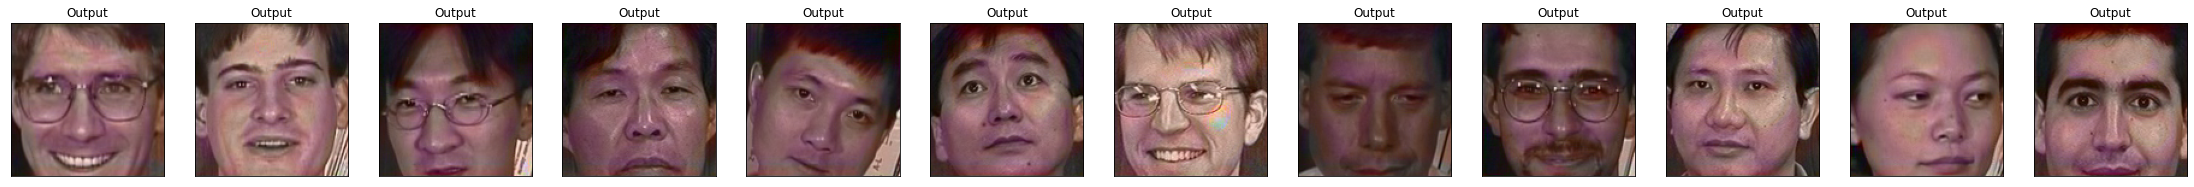

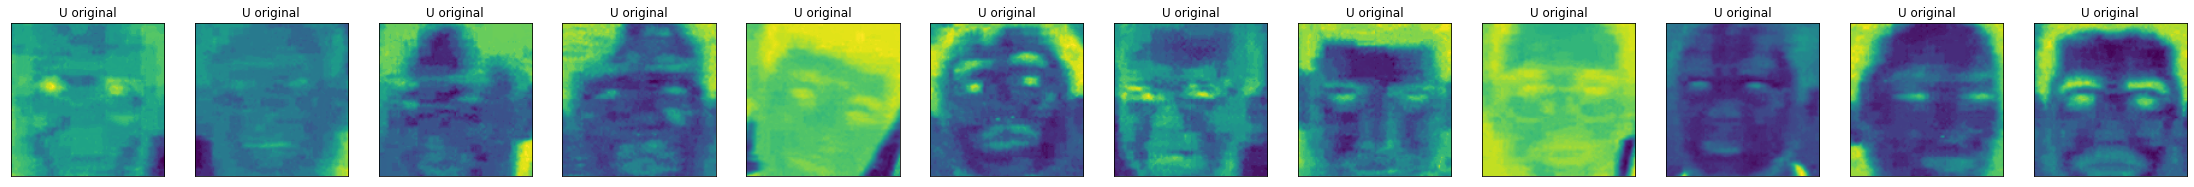

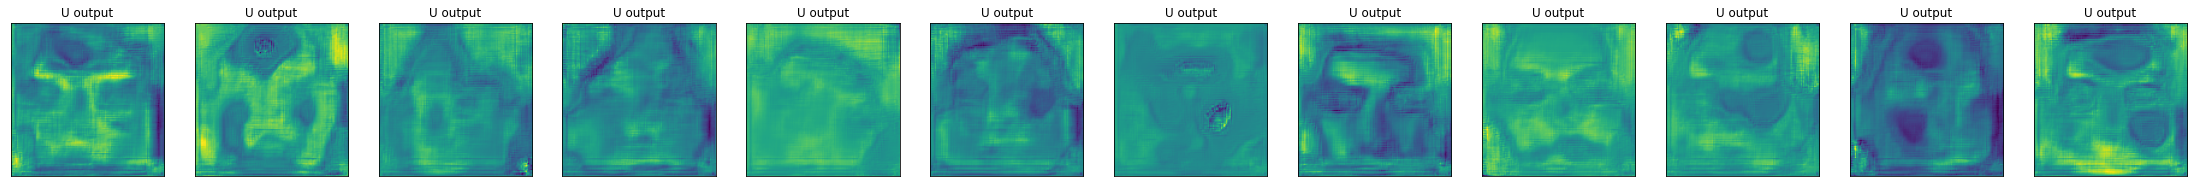

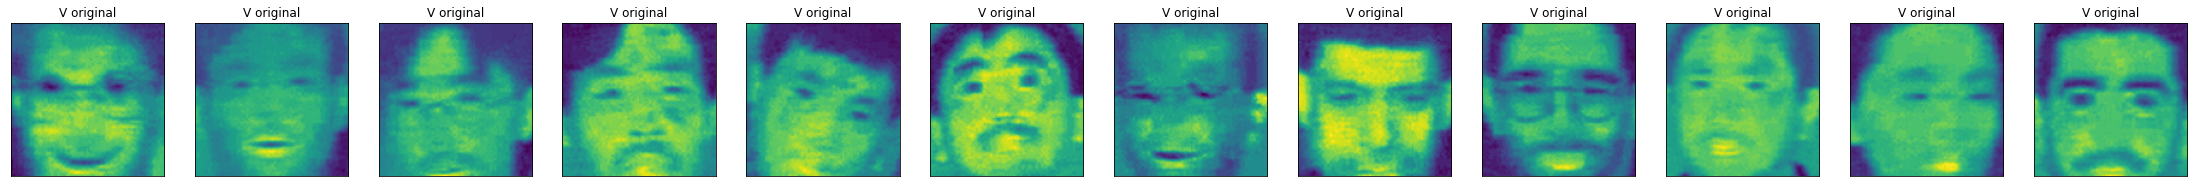

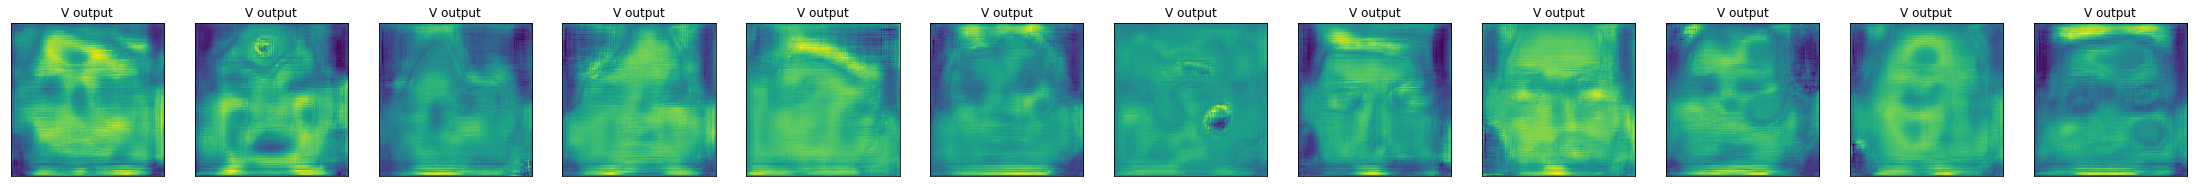

In [12]:
# Get output for training image Y channel
output = generator.predict(train_y)
result = np.zeros((train_y.shape[0], train_y.shape[1], train_y.shape[2], 3))
result[:,:,:,0] = train_y[:,:,:,0]
result[:,:,:,1:] = output

# Graph results
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.gca().axes.get_yaxis().set_visible(False)
  plt.gca().axes.get_xaxis().set_visible(False)
  plt.title("Original")
  plt.imshow(train_images[i+index_offset])

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.gca().axes.get_yaxis().set_visible(False)
  plt.gca().axes.get_xaxis().set_visible(False)
  plt.title("Output")
  plt.imshow(tf.image.yuv_to_rgb(result[i+index_offset]))

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.gca().axes.get_yaxis().set_visible(False)
  plt.gca().axes.get_xaxis().set_visible(False)
  plt.title("U original")
  plt.imshow(train_yuv[i+index_offset,:,:,1])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.gca().axes.get_yaxis().set_visible(False)
  plt.gca().axes.get_xaxis().set_visible(False)
  plt.title("U output")
  plt.imshow(result[i+index_offset,:,:,1])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.gca().axes.get_yaxis().set_visible(False)
  plt.gca().axes.get_xaxis().set_visible(False)
  plt.title("V original")
  plt.imshow(train_yuv[i+index_offset,:,:,2])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.gca().axes.get_yaxis().set_visible(False)
  plt.gca().axes.get_xaxis().set_visible(False)
  plt.title("V output")
  plt.imshow(result[i+index_offset,:,:,2])

# Testing Results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

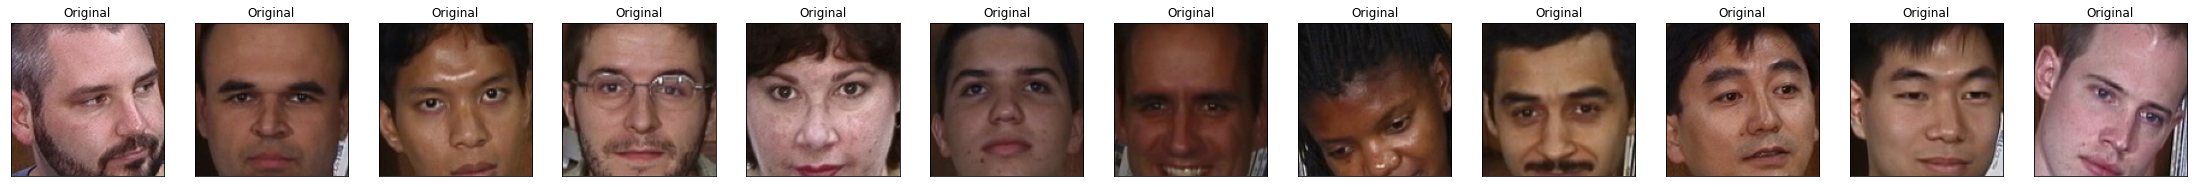

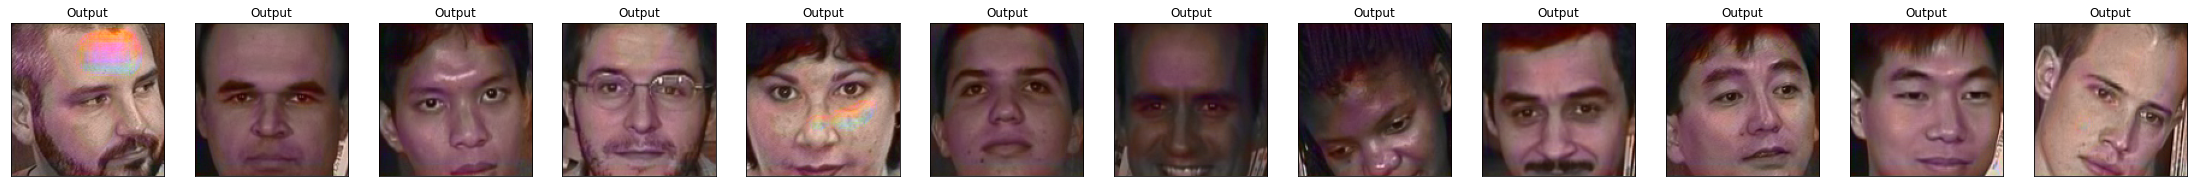

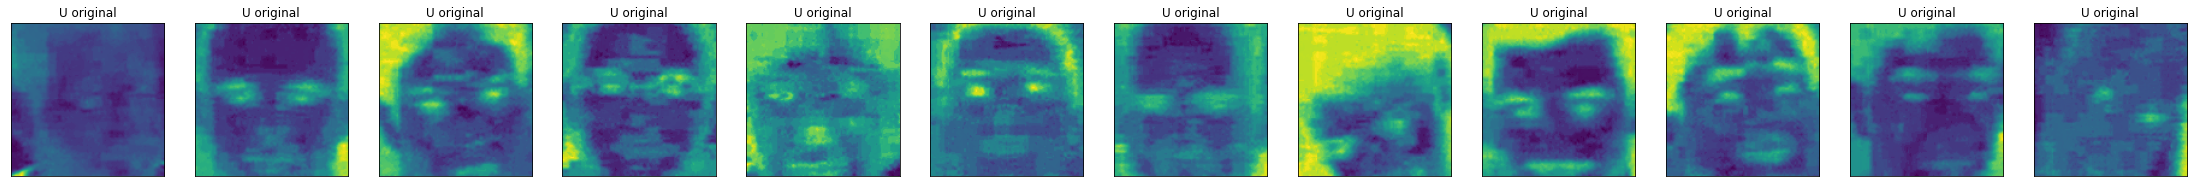

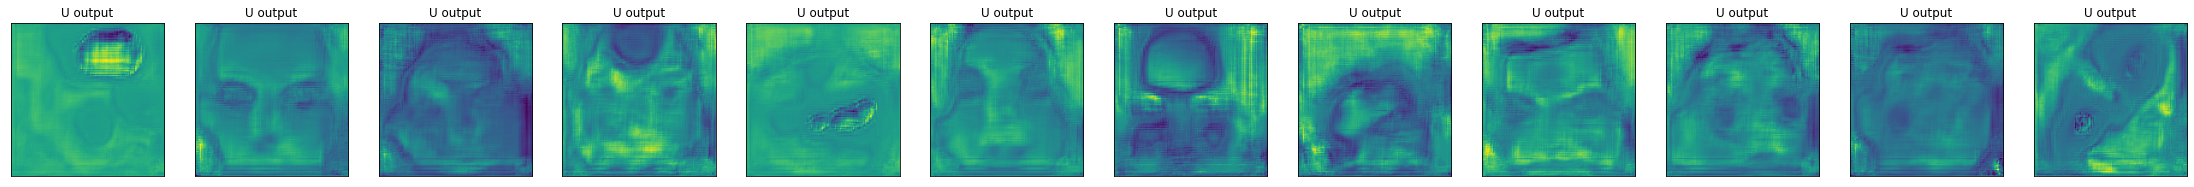

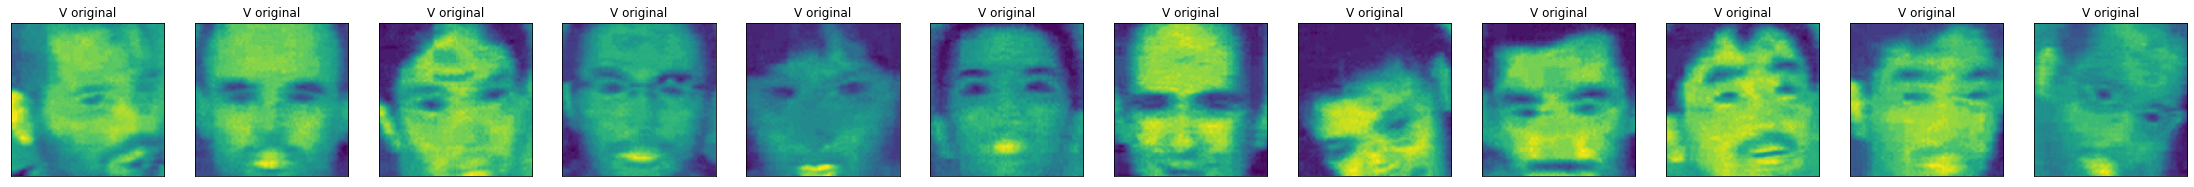

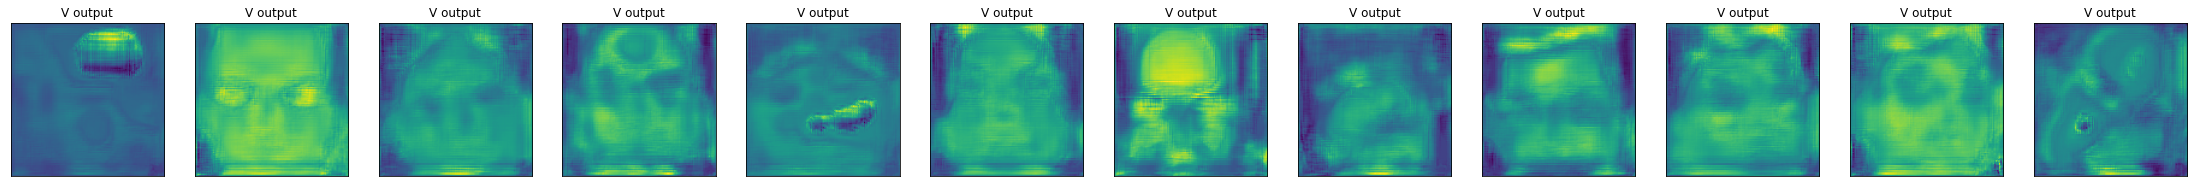

In [13]:
# Get output for testing image Y channel
output = generator.predict(test_y)
result = np.zeros((test_yuv.shape[0], test_yuv.shape[1], test_yuv.shape[2], 3))
result[:,:,:,0] = test_y[:,:,:,0]
result[:,:,:,1:] = output
  
index_offset = 20
# Graph results
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.gca().axes.get_yaxis().set_visible(False)
  plt.gca().axes.get_xaxis().set_visible(False)
  plt.title("Original")
  plt.imshow(test_images[i+index_offset])

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.gca().axes.get_yaxis().set_visible(False)
  plt.gca().axes.get_xaxis().set_visible(False)
  plt.title("Output")
  plt.imshow(tf.image.yuv_to_rgb(result[i+index_offset]))

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.gca().axes.get_yaxis().set_visible(False)
  plt.gca().axes.get_xaxis().set_visible(False)
  plt.title("U original")
  plt.imshow(test_yuv[i+index_offset,:,:,1])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.gca().axes.get_yaxis().set_visible(False)
  plt.gca().axes.get_xaxis().set_visible(False)
  plt.title("U output")
  plt.imshow(result[i+index_offset,:,:,1])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.gca().axes.get_yaxis().set_visible(False)
  plt.gca().axes.get_xaxis().set_visible(False)
  plt.title("V original")
  plt.imshow(test_yuv[i+index_offset,:,:,2])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.gca().axes.get_yaxis().set_visible(False)
  plt.gca().axes.get_xaxis().set_visible(False)
  plt.title("V output")
  plt.imshow(result[i+index_offset,:,:,2])